
# Reproducing Heavy-Tailed Class Imbalance Findings (Adam vs. SGD) — CPU-Friendly

**Paper:** *Heavy-Tailed Class Imbalance and Why Adam Outperforms Gradient Descent on Language Models* (Kunstner, Yadav, Milligan, Schmidt, Bietti, 2024)  
**Goal:** Recreate the core experiments and plots—on CPU—showing why **Adam** outperforms **(S)GD** under **heavy-tailed class imbalance**.

> **What you will see**
> - Synthetic **linear softmax** experiment reproducing Fig. 4 (and the gradient–Hessian correlation of Fig. 7–8)
> - **Optimizer ablation** (GD / Adam / Normalized-GD / SignGD ± momentum) reproducing Fig. 5 trends
> - A **CNN** on a *barcoded* MNIST-like dataset (balanced vs. heavy-tailed labels) mirroring Fig. 2
> - A **tiny ResNet-like** experiment on synthetic "ImageNet-like" images (balanced vs. heavy-tailed) mirroring Fig. 3 (CPU-scale)
> - **Quadratic toy** (Sec. 3.1) illustrating the core intuition (Fig. 6)
> - **Loss reweighting** (Appendix F): upweighting rare classes helps SGD

All code defaults to **small CPU-friendly sizes**. You can increase sizes/epochs to accentuate effects at the expense of runtime.


## 0. Environment & Utilities

In [2]:

import math
import time
import numpy as np
import matplotlib.pyplot as plt

# Use PyTorch for NN experiments
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Reproducibility
def set_seed(seed=1337):
    np.random.seed(seed)
    torch.manual_seed(seed)
set_seed()

device = torch.device("cpu")
print("Using device:", device)

# ---------- Plotting helpers (matplotlib only, no seaborn) ----------
def plot_one(x, y, title="", xlabel="", ylabel=""):
    plt.figure()
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def plot_multi(lines, labels, title="", xlabel="", ylabel=""):
    plt.figure()
    for arr in lines:
        plt.plot(arr)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(labels)
    plt.show()

def plot_scatter(x, y, c=None, title="", xlabel="", ylabel=""):
    plt.figure()
    if c is None:
        plt.scatter(x, y, s=10)
    else:
        sc = plt.scatter(x, y, c=c, s=10)
        plt.colorbar(sc, label="class frequency rank (low->high)")
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.show()

def heatmap(mat, title=""):
    plt.figure()
    plt.imshow(mat, aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.show()

# ---------- Heavy-tail utilities ----------
def zipf_probs(c, s=1.0):
    """Return probabilities pi_k proportional to 1/k**s for k=1..c, normalized."""
    ranks = np.arange(1, c+1, dtype=np.float64)
    unnorm = 1.0 / np.power(ranks, s)
    probs = unnorm / unnorm.sum()
    return probs

def make_heavy_tailed_labels(n, c, s=1.0, min_per_class=1):
    """Sample n labels from a Zipf-like distribution over c classes."""
    pi = zipf_probs(c, s)
    # ensure each class appears at least min_per_class (if feasible)
    y = []
    reserve = min_per_class * c
    if reserve <= n:
        for k in range(c):
            y.extend([k] * min_per_class)
        remaining = n - reserve
        if remaining > 0:
            y.extend(np.random.choice(c, size=remaining, p=pi))
    else:
        y = list(np.random.choice(c, size=n, p=pi))
    y = np.array(y, dtype=np.int64)
    np.random.shuffle(y)
    return y, pi

def class_counts(y, c=None):
    if c is None:
        c = int(y.max()) + 1
    counts = np.bincount(y, minlength=c)
    return counts

def frequency_groups(y, c=None, n_groups=10):
    """Return list of arrays of class ids grouped by frequency deciles (approx equal data per group)."""
    if c is None:
        c = int(y.max()) + 1
    counts = class_counts(y, c)
    order = np.argsort(-counts)  # most frequent first
    counts_sorted = counts[order]
    cum = counts_sorted.cumsum()
    total = counts_sorted.sum()
    groups = []
    target = total / n_groups
    start = 0
    for g in range(n_groups - 1):
        end = np.searchsorted(cum, (g+1) * target)
        groups.append(order[start:end])
        start = end
    groups.append(order[start:])
    return groups

def plot_class_hist(y, title="Samples per class (sorted)"):
    counts = class_counts(y)
    counts_sorted = np.sort(counts)[::-1]
    plt.figure()
    plt.plot(counts_sorted)
    plt.yscale("log")
    plt.xscale("log")
    plt.title(title)
    plt.xlabel("Class rank (by frequency)")
    plt.ylabel("# samples (log)")
    plt.show()

# ---------- Linear softmax model (NumPy) ----------
class LinearSoftmax:
    """C-class linear softmax (no bias for simplicity)."""
    def __init__(self, d, c):
        self.W = np.zeros((c, d), dtype=np.float64)

    def softmax(self, Z):
        Z = Z - Z.max(axis=1, keepdims=True)
        expZ = np.exp(Z)
        return expZ / np.sum(expZ, axis=1, keepdims=True)

    def forward(self, X):
        return X @ self.W.T   # [n, c]

    def loss_and_grad(self, X, y, sample_weights=None):
        n, d = X.shape
        logits = self.forward(X)
        P = self.softmax(logits)
        Y = np.zeros_like(P); Y[np.arange(n), y] = 1.0
        if sample_weights is None:
            loss = -np.mean(np.log(P[np.arange(n), y] + 1e-12))
            G = (P - Y) / n
        else:
            w = sample_weights
            w = w / w.mean()
            loss = -np.sum(w * np.log(P[np.arange(n), y] + 1e-12)) / np.sum(w)
            G = (P - Y) * (w[:, None] / np.sum(w))
        gradW = G.T @ X
        return loss, gradW, P

    def step_gd(self, gradW, lr):
        self.W -= lr * gradW

    def step_sign(self, gradW, lr, momentum=None):
        if momentum is not None:
            momentum[:] = 0.9*momentum + np.sign(gradW)
            self.W -= lr * momentum
        else:
            self.W -= lr * np.sign(gradW)

    def step_normgd(self, gradW, lr, momentum=None):
        g = gradW
        gnorm = np.linalg.norm(g)
        if gnorm > 0:
            g = g / gnorm
        if momentum is not None:
            momentum[:] = 0.9*momentum + g
            self.W -= lr * momentum
        else:
            self.W -= lr * g

def group_losses_linear(model, X, y, groups):
    n = X.shape[0]
    logits = model.forward(X)
    P = model.softmax(logits)
    losses = -np.log(P[np.arange(n), y] + 1e-12)
    C = int(y.max()) + 1
    by_class = [[] for _ in range(C)]
    for i, cls in enumerate(y):
        by_class[cls].append(i)
    out = []
    for group in groups:
        idx = []
        for cls in group:
            idx.extend(by_class[cls])
        if len(idx) == 0:
            out.append(float('nan'))
        else:
            out.append(np.mean(losses[idx]))
    return out

# ---------- Synthetic "image" generators ----------
def make_synthetic_image(cls, H=28, W=28, rng=None):
    """Simple pattern for a 'base' class image: 10 base classes with distinct blobs/stripes."""
    if rng is None:
        rng = np.random.RandomState(0)
    img = rng.rand(H, W) * 0.1  # low-level noise background
    k = cls % 10
    if k == 0:
        img[:H//3, :W//3] += 1.0
    elif k == 1:
        img[-H//3:, :W//3] += 1.0
    elif k == 2:
        img[:H//3, -W//3:] += 1.0
    elif k == 3:
        img[-H//3:, -W//3:] += 1.0
    elif k == 4:
        img[:, :2] += 1.0
    elif k == 5:
        img[:, -2:] += 1.0
    elif k == 6:
        img[:2, :] += 1.0
    elif k == 7:
        img[-2:, :] += 1.0
    elif k == 8:
        img[H//2-2:H//2+2, :] += 1.0
    elif k == 9:
        img[:, W//2-2:W//2+2] += 1.0
    img = np.clip(img, 0.0, 1.0)
    return img.astype(np.float32)

def overlay_barcode(img, code, bits=10):
    """Overlay a small barcode (bits) in the corner to create many rare classes."""
    H, W = img.shape
    out = img.copy()
    for i in range(bits):
        val = (code >> i) & 1
        if val:
            out[i:i+2, i:i+2] = 1.0
        else:
            out[i:i+2, i:i+2] = 0.2
    return out

class SimpleImageDataset(Dataset):
    def __init__(self, images, labels):
        self.X = torch.from_numpy(np.stack(images)).unsqueeze(1)  # [N,1,H,W]
        self.y = torch.from_numpy(np.array(labels, dtype=np.int64))
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

# ---------- Tiny CNN and Tiny ResNet ----------
class TinyCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc = nn.Linear(32*7*7, num_classes)  # for 28x28 inputs
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)
    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = F.relu(out + identity)
        return out

class TinyResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )
        self.layer1 = ResidualBlock(16)
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(16, num_classes)
    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total = 0.0
    for xb, yb in loader:
        xb = xb.to(device); yb = yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total += loss.item() * xb.size(0)
    return total / len(loader.dataset)

@torch.no_grad()
def eval_group_losses(model, dataset, groups, batch_size=128):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    criterion = nn.CrossEntropyLoss(reduction="none")
    model.eval()
    losses = []
    labels = []
    for xb, yb in loader:
        xb = xb.to(device); yb = yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)  # [B]
        losses.append(loss.cpu().numpy())
        labels.append(yb.cpu().numpy())
    losses = np.concatenate(losses)
    labels = np.concatenate(labels)
    by_class = {}
    for i, cls in enumerate(labels):
        by_class.setdefault(int(cls), []).append(i)
    L = []
    for g in groups:
        idx = []
        for cls in g:
            idx.extend(by_class.get(int(cls), []))
        if len(idx) == 0:
            L.append(float('nan'))
        else:
            L.append(float(np.mean(losses[idx])))
    return L

print("Setup complete.")


Using device: cpu
Setup complete.



## 1. Linear Softmax on Synthetic Heavy-Tailed Labels (Fig. 4, Fig. 7–8)

This section reproduces the main phenomenon with a linear softmax classifier:
- Class frequencies follow a power-law (Zipf), forming a heavy tail.
- GD makes very slow progress on low-frequency classes.
- Adam makes progress across all classes.
- We also compute the gradient–Hessian correlation across class blocks and visualize Hessian blocks.


X: (6000, 64) y: (6000,) unique classes: 256


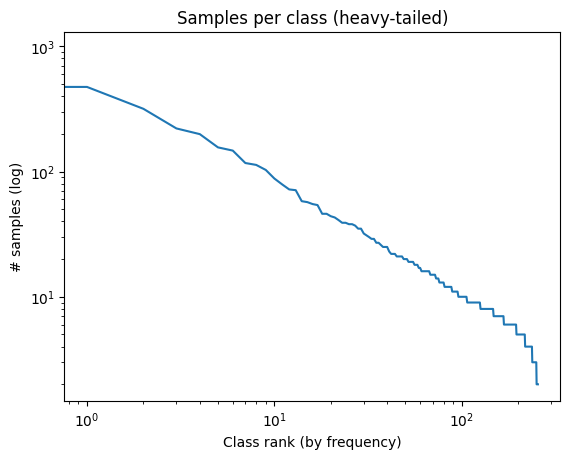

Formed 10 frequency groups (approx equal data mass per group).


In [3]:

# --- Synthetic dataset ---
n = 6000     # number of samples (CPU-friendly)
d = 64       # feature dimension
c = 256      # number of classes
s_zipf = 1.0

# Generate features (aligned, positive quadrant encourages class coupling)
X = np.random.rand(n, d).astype(np.float64)
y, pi = make_heavy_tailed_labels(n, c, s=s_zipf, min_per_class=1)

print("X:", X.shape, "y:", y.shape, "unique classes:", len(np.unique(y)))
plot_class_hist(y, title="Samples per class (heavy-tailed)")
groups = frequency_groups(y, c=c, n_groups=10)
print("Formed", len(groups), "frequency groups (approx equal data mass per group).")


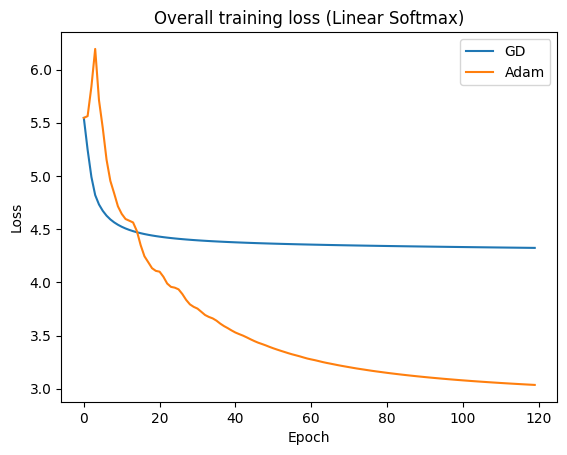

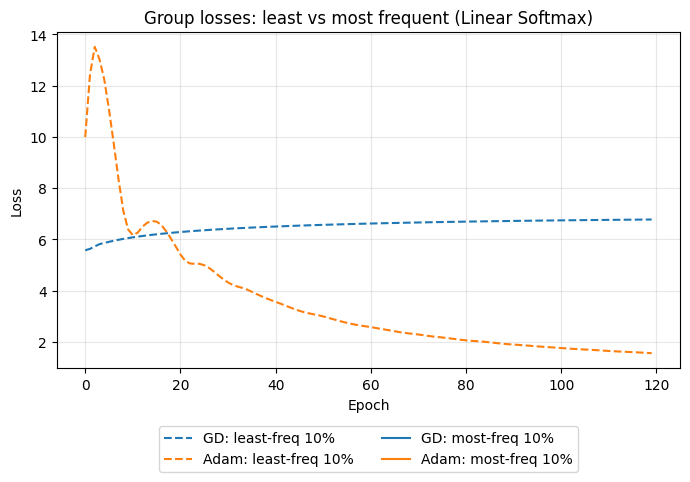

In [4]:

# --- Train LinearSoftmax with GD vs Adam ---
lin_gd = LinearSoftmax(d, c)
lin_adam = LinearSoftmax(d, c)

# Adam states
m_adam = np.zeros_like(lin_adam.W)
v_adam = np.zeros_like(lin_adam.W)
beta1, beta2, eps = 0.9, 0.999, 1e-8

epochs = 120
lr_gd = 0.5
lr_adam = 0.1

overall_loss_gd, overall_loss_adam = [], []
group_loss_gd_hist, group_loss_adam_hist = [], []

for t in range(epochs):
    # GD
    loss_gd, gradW_gd, P_gd = lin_gd.loss_and_grad(X, y)
    lin_gd.step_gd(gradW_gd, lr_gd)
    overall_loss_gd.append(loss_gd)
    group_loss_gd_hist.append(group_losses_linear(lin_gd, X, y, groups))

    # Adam
    loss_adam, gradW_adam, P_adam = lin_adam.loss_and_grad(X, y)
    m_adam = beta1*m_adam + (1-beta1)*gradW_adam
    v_adam = beta2*v_adam + (1-beta2)*(gradW_adam**2)
    mhat = m_adam / (1 - beta1**(t+1))
    vhat = v_adam / (1 - beta2**(t+1))
    lin_adam.W -= lr_adam * mhat / (np.sqrt(vhat) + eps)
    overall_loss_adam.append(loss_adam)
    group_loss_adam_hist.append(group_losses_linear(lin_adam, X, y, groups))

plt.figure()
plt.plot(overall_loss_gd, label="GD")
plt.plot(overall_loss_adam, label="Adam")
plt.title("Overall training loss (Linear Softmax)")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.show()

least_idx = -1  # last group = least frequent
most_idx = 0    # first group = most frequent

# Extract the losses over epochs
gd_least = [g[least_idx] for g in group_loss_gd_hist]
adam_least = [a[least_idx] for a in group_loss_adam_hist]
gd_most = [g[most_idx] for g in group_loss_gd_hist]
adam_most = [a[most_idx] for a in group_loss_adam_hist]

plt.figure(figsize=(7,5))

# Use different styles for each
plt.plot(gd_least, label="GD: least-freq 10%", color="tab:blue", linestyle="--")
plt.plot(adam_least, label="Adam: least-freq 10%", color="tab:orange", linestyle="--")
plt.plot(np.array(gd_most)+0.1, label="GD: most-freq 10%", color="tab:blue", linestyle="-")   # small offset
plt.plot(np.array(adam_most)+0.1, label="Adam: most-freq 10%", color="tab:orange", linestyle="-")

plt.title("Group losses: least vs most frequent (Linear Softmax)", fontsize=12)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=0.3)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.tight_layout()
plt.show()


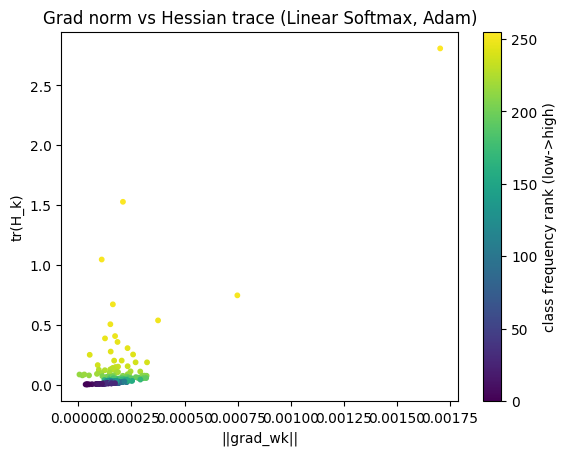

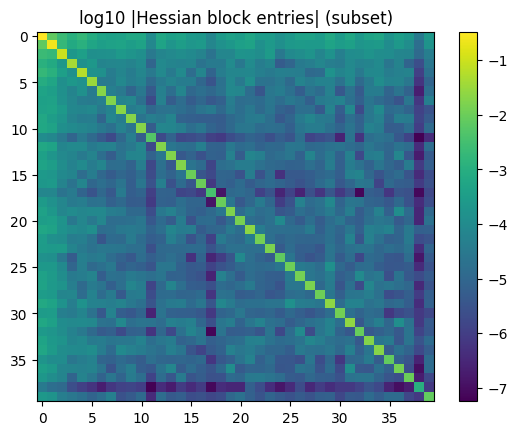

In [12]:

# --- Gradient–Hessian correlation across class blocks (Fig. 7-like) ---
def grad_hess_per_class(model, X, y):
    """Return grad_norm[k], hess_trace[k] for each class k (diagonal block approximation)."""
    n, d = X.shape
    C = model.W.shape[0]
    logits = X @ model.W.T
    logits = logits - logits.max(axis=1, keepdims=True)
    expZ = np.exp(logits)
    P = expZ / expZ.sum(axis=1, keepdims=True)
    Y = np.zeros_like(P); Y[np.arange(n), y] = 1.0
    R = (P - Y) / n  # [n, C]
    grad_norm = np.linalg.norm(R.T @ X, axis=1)  # per class
    x_sqnorm = (X**2).sum(axis=1)
    hess_trace = (P * (1 - P)).T @ x_sqnorm / n  # per class
    return grad_norm, hess_trace

g_adam, h_adam = grad_hess_per_class(lin_adam, X, y)

# color by class frequency rank (low->high)
counts = class_counts(y, c)
rank_order = np.argsort(counts)  # low to high
rank = np.empty_like(rank_order)
rank[rank_order] = np.arange(c)

plot_scatter(g_adam, h_adam, c=rank, title="Grad norm vs Hessian trace (Linear Softmax, Adam)",
             xlabel="||grad_wk||", ylabel="tr(H_k)")

# --- Hessian block heatmap (subset) (Fig. 8-like) ---
K = 40  # number of classes to sample
Dsub = 40  # number of feature dims to sample
rng = np.random.RandomState(0)
cls_subset = np.sort(rng.choice(c, size=K, replace=False))
dim_subset = np.sort(rng.choice(d, size=Dsub, replace=False))

logits = X @ lin_adam.W.T
logits = logits - logits.max(axis=1, keepdims=True)
P = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)
x_sq_sub = (X[:, dim_subset]**2).sum(axis=1)  # [n]
H = np.zeros((K, K), dtype=np.float64)
for a, ka in enumerate(cls_subset):
    for b, kb in enumerate(cls_subset):
        if ka == kb:
            H[a,b] = np.mean(P[:,ka]*(1-P[:,ka])*x_sq_sub)
        else:
            H[a,b] = np.mean(-P[:,ka]*P[:,kb]*x_sq_sub)

Hlog = np.log10(np.abs(H) + 1e-20)
heatmap(Hlog, title="log10 |Hessian block entries| (subset)")



## 2. Optimizer Ablation: GD / Adam / Normalized-GD / SignGD (± momentum) (Fig. 5)

We compare optimizers on the same linear-softmax heavy-tailed task and track loss on low-frequency classes.


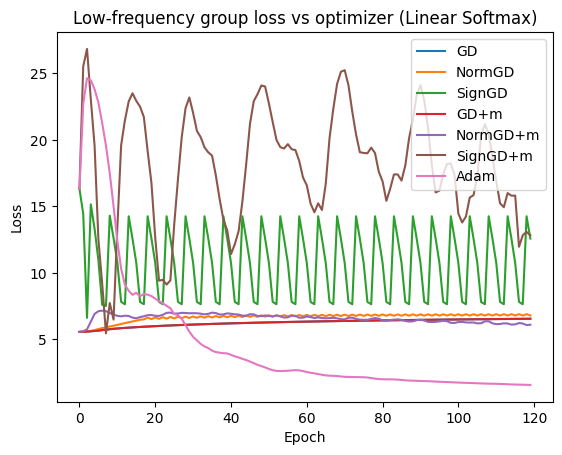

In [13]:

def run_optimizer(model, X, y, kind="GD", lr=0.2, epochs=100):
    mom = None
    if "sign+m" in kind or "norm+m" in kind:
        mom = np.zeros_like(model.W)
    losses_overall = []
    low_group = frequency_groups(y, c=c, n_groups=10)[-1]  # least frequent group
    low_losses = []
    # Adam states local to this run
    m_ad = np.zeros_like(model.W); v_ad = np.zeros_like(model.W)
    b1, b2, eps = 0.9, 0.999, 1e-8
    for t in range(epochs):
        loss, gradW, _ = model.loss_and_grad(X, y)
        losses_overall.append(loss)
        if kind == "GD":
            model.step_gd(gradW, lr)
        elif kind == "Adam":
            m_ad = b1*m_ad + (1-b1)*gradW
            v_ad = b2*v_ad + (1-b2)*(gradW**2)
            mhat = m_ad / (1 - b1**(t+1)); vhat = v_ad / (1 - b2**(t+1))
            model.W -= lr * mhat / (np.sqrt(vhat) + eps)
        elif kind == "norm":
            model.step_normgd(gradW, lr, momentum=None)
        elif kind == "norm+m":
            model.step_normgd(gradW, lr, momentum=mom)
        elif kind == "sign":
            model.step_sign(gradW, lr, momentum=None)
        elif kind == "sign+m":
            model.step_sign(gradW, lr, momentum=mom)
        else:
            raise ValueError(kind)
        gl = group_losses_linear(model, X, y, [low_group])[0]
        low_losses.append(gl)
    return losses_overall, low_losses

opt_kinds = ["GD", "norm", "sign", "GD", "norm+m", "sign+m", "Adam"]
labels = ["GD", "NormGD", "SignGD", "GD+m", "NormGD+m", "SignGD+m", "Adam"]

results_low = []
for kind in opt_kinds:
    m = LinearSoftmax(d, c)
    lo, low = run_optimizer(m, X, y, kind=("GD" if kind=="GD" else kind), lr=0.2, epochs=120)
    results_low.append(low)

plt.figure()
for arr, lab in zip(results_low, labels):
    plt.plot(arr, label=lab)
plt.title("Low-frequency group loss vs optimizer (Linear Softmax)")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.show()


## 3. Up-weighting Rare Classes Helps SGD (Appendix F)

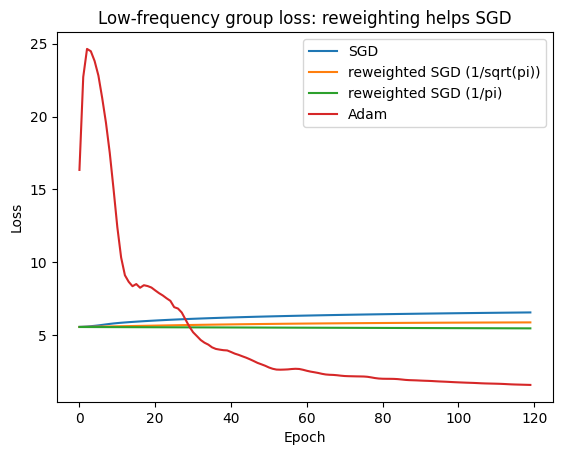

In [15]:

# Compute class weights
counts = class_counts(y, c)
pi_emp = counts / counts.sum()
w_inv = 1.0 / (pi_emp + 1e-12)
w_inv_sqrt = 1.0 / np.sqrt(pi_emp + 1e-12)

def run_sgd_weighted(X, y, weights, lr=0.2, epochs=120):
    model = LinearSoftmax(d, c)
    overall = []
    low_group = frequency_groups(y, c=c, n_groups=10)[-1]
    low_hist = []
    ws = np.array([weights[yy] for yy in y], dtype=np.float64)
    for t in range(epochs):
        loss, gradW, _ = model.loss_and_grad(X, y, sample_weights=ws)
        model.step_gd(gradW, lr)
        overall.append(loss)
        low_hist.append(group_losses_linear(model, X, y, [low_group])[0])
    return overall, low_hist

overall_sgd, low_sgd = run_sgd_weighted(X, y, np.ones_like(pi_emp), lr=0.2, epochs=120)
overall_rsgd_sqrt, low_rsgd_sqrt = run_sgd_weighted(X, y, w_inv_sqrt, lr=0.2, epochs=120)
overall_rsgd, low_rsgd = run_sgd_weighted(X, y, w_inv, lr=0.2, epochs=120)

# Adam baseline
m = LinearSoftmax(d, c)
m_ad, v_ad = np.zeros_like(m.W), np.zeros_like(m.W)
overall_adam, low_adam = [], []
for t in range(120):
    loss, gradW, _ = m.loss_and_grad(X, y)
    m_ad = 0.9*m_ad + 0.1*gradW
    v_ad = 0.999*v_ad + 0.001*(gradW**2)
    mhat = m_ad/(1-0.9**(t+1)); vhat = v_ad/(1-0.999**(t+1))
    m.W -= 0.2 * mhat / (np.sqrt(vhat)+1e-8)
    overall_adam.append(loss)
    low_adam.append(group_losses_linear(m, X, y, [frequency_groups(y, c=c, n_groups=10)[-1]])[0])

plt.figure()
plt.plot(low_sgd, label="SGD")
plt.plot(low_rsgd_sqrt, label="reweighted SGD (1/sqrt(pi))")
plt.plot(low_rsgd, label="reweighted SGD (1/pi)")
plt.plot(low_adam, label="Adam")
plt.title("Low-frequency group loss: reweighting helps SGD")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.show()


## 4. CNN on Barcoded MNIST-like Data (Fig. 2)

Base: 2000 Tail: 1000 Combined: 3000


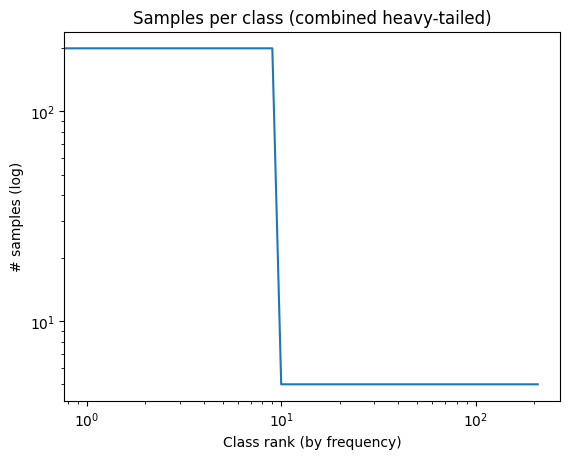

In [16]:

# --- Build datasets ---
rng = np.random.RandomState(123)

# Balanced base (10 classes x ~200 each)
base_classes = 10
base_per_class = 200
images_base = []
labels_base = []
for cls in range(base_classes):
    for _ in range(base_per_class):
        images_base.append(make_synthetic_image(cls, H=28, W=28, rng=rng))
        labels_base.append(cls)

# Barcoded tail: 200 rare classes x 5 samples each
tail_classes = 200
tail_per_class = 5
images_tail = []
labels_tail = []
for tidx in range(tail_classes):
    code = tidx  # unique barcode id
    for _ in range(tail_per_class):
        base_img = make_synthetic_image(rng.randint(0, base_classes), H=28, W=28, rng=rng)
        img = overlay_barcode(base_img, code, bits=10)
        images_tail.append(img)
        labels_tail.append(base_classes + tidx)  # new class id

# Datasets
ds_base = SimpleImageDataset(images_base, labels_base)
ds_tail = SimpleImageDataset(images_tail, labels_tail)
# Combined heavy-tailed
images_comb = images_base + images_tail
labels_comb = labels_base + labels_tail
ds_comb = SimpleImageDataset(images_comb, labels_comb)

print("Base:", len(ds_base), "Tail:", len(ds_tail), "Combined:", len(ds_comb))
y_comb = np.array(labels_comb)
plot_class_hist(y_comb, title="Samples per class (combined heavy-tailed)")

# Frequency groups on combined set
c_comb = int(y_comb.max()) + 1
groups_comb = frequency_groups(y_comb, c=c_comb, n_groups=10)


/var/folders/0x/0llkz83n2nsdd2v5qvtllvjr0000gn/T/ipykernel_7057/3518758470.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  model = TinyCNN(num_classes=int(np.array(ds.y).max())+1).to(device)
/var/folders/0x/0llkz83n2nsdd2v5qvtllvjr0000gn/T/ipykernel_7057/3518758470.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  model = TinyCNN(num_classes=int(np.array(ds.y).max())+1).to(device)


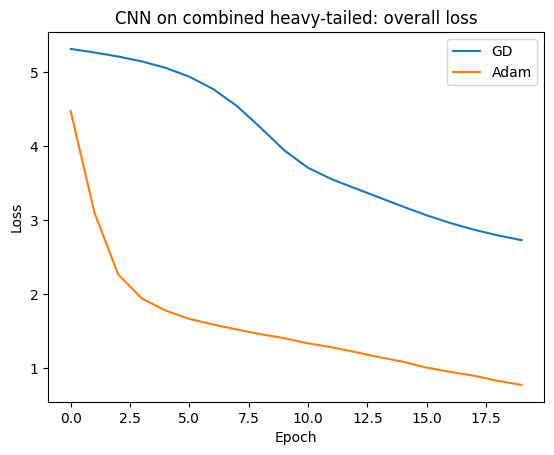

Group losses (GD) [least, most]: [6.570122241973877, 0.7186725735664368]
Group losses (Adam) [least, most]: [1.8954393863677979, 0.030583081766963005]


In [17]:

# --- Train TinyCNN with GD vs Adam on combined heavy-tailed data ---
batch_size = 256
loader = DataLoader(ds_comb, batch_size=batch_size, shuffle=True)

def train_cnn(ds, opt_kind="GD", epochs=20, lr=1e-2):
    model = TinyCNN(num_classes=int(np.array(ds.y).max())+1).to(device)
    if opt_kind == "GD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.0)
    elif opt_kind == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        raise ValueError
    criterion = nn.CrossEntropyLoss()
    losses = []
    for ep in range(epochs):
        loss = train_epoch(model, DataLoader(ds, batch_size=batch_size, shuffle=True), optimizer, criterion)
        losses.append(loss)
    return model, losses

model_gd, losses_gd = train_cnn(ds_comb, "GD", epochs=20, lr=5e-3)
model_adam, losses_adam = train_cnn(ds_comb, "Adam", epochs=20, lr=1e-3)

plt.figure()
plt.plot(losses_gd, label="GD")
plt.plot(losses_adam, label="Adam")
plt.title("CNN on combined heavy-tailed: overall loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

# Group losses (most vs least frequent)
low_group = groups_comb[-1]
high_group = groups_comb[0]
gl_gd = eval_group_losses(model_gd, ds_comb, [low_group, high_group])
gl_adam = eval_group_losses(model_adam, ds_comb, [low_group, high_group])
print("Group losses (GD) [least, most]:", gl_gd)
print("Group losses (Adam) [least, most]:", gl_adam)


## 5. Tiny ResNet on Synthetic Image Data (Fig. 3)

Training TinyResNet (balanced)...


/var/folders/0x/0llkz83n2nsdd2v5qvtllvjr0000gn/T/ipykernel_7057/2699380007.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  model = TinyResNet(num_classes=int(np.array(ds.y).max())+1).to(device)


[SGD] Epoch 01/10: loss = 4.1250
[SGD] Epoch 02/10: loss = 4.0811
[SGD] Epoch 03/10: loss = 4.0449
[SGD] Epoch 04/10: loss = 4.0163
[SGD] Epoch 05/10: loss = 3.9920
[SGD] Epoch 06/10: loss = 3.9690
[SGD] Epoch 07/10: loss = 3.9434
[SGD] Epoch 08/10: loss = 3.9175
[SGD] Epoch 09/10: loss = 3.8905
[SGD] Epoch 10/10: loss = 3.8629
[SGD] Finished in 52.6s | Final loss: 3.8629
[Adam] Epoch 01/10: loss = 4.0617
[Adam] Epoch 02/10: loss = 3.9614
[Adam] Epoch 03/10: loss = 3.8691
[Adam] Epoch 04/10: loss = 3.7715
[Adam] Epoch 05/10: loss = 3.6693
[Adam] Epoch 06/10: loss = 3.5642
[Adam] Epoch 07/10: loss = 3.4576
[Adam] Epoch 08/10: loss = 3.3506
[Adam] Epoch 09/10: loss = 3.2464
[Adam] Epoch 10/10: loss = 3.1482
[Adam] Finished in 55.8s | Final loss: 3.1482

Training TinyResNet (heavy-tailed)...
[SGD] Epoch 01/10: loss = 4.0279
[SGD] Epoch 02/10: loss = 3.7172
[SGD] Epoch 03/10: loss = 3.4613
[SGD] Epoch 04/10: loss = 3.3258
[SGD] Epoch 05/10: loss = 3.2496
[SGD] Epoch 06/10: loss = 3.1938
[S

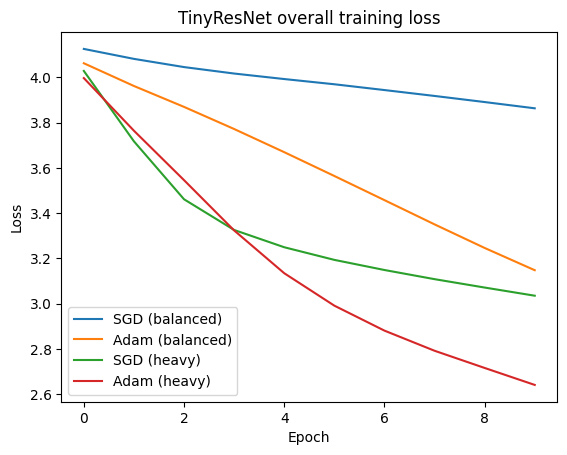

/var/folders/0x/0llkz83n2nsdd2v5qvtllvjr0000gn/T/ipykernel_7057/2699380007.py:77: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_ht = np.array(ds_ht.y)



TinyResNet heavy-tailed group losses [least, most]:
  SGD : [4.9934163093566895, nan]
  Adam: [5.069329261779785, nan]


In [20]:
from time import time
# Optional: uncomment if you want a progress bar
# !pip install tqdm
# from tqdm.notebook import tqdm

# Synthetic image datasets (balanced vs heavy-tailed)
def make_synth_images(num_classes=50, total_samples=5000, heavy=False, rng=None):
    if rng is None: 
        rng = np.random.RandomState(0)
    if heavy:
        pi = zipf_probs(num_classes, s=1.0)
        counts = np.maximum(1, (pi * total_samples).astype(int))
        diff = total_samples - counts.sum()
        counts[0] += diff
    else:
        per = total_samples // num_classes
        counts = np.array([per]*num_classes)
        counts[0] += (total_samples - per*num_classes)
    images, labels = [], []
    for cls in range(num_classes):
        for _ in range(counts[cls]):
            img = make_synthetic_image(cls, H=32, W=32, rng=rng)
            images.append(img)
            labels.append(cls)
    return SimpleImageDataset(images, labels)

num_classes = 60
total_samples = 6000
ds_bal = make_synth_images(num_classes, total_samples, heavy=False, rng=np.random.RandomState(1))
ds_ht = make_synth_images(num_classes, total_samples, heavy=True, rng=np.random.RandomState(2))

def train_tiny_resnet(ds, opt="SGD", epochs=10, lr=1e-2, verbose=True):
    """Train TinyResNet with epoch-by-epoch logging."""
    model = TinyResNet(num_classes=int(np.array(ds.y).max())+1).to(device)
    if opt == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    losses = []
    loader = DataLoader(ds, batch_size=256, shuffle=True)
    
    t0 = time()
    # If you installed tqdm, replace range(...) with tqdm(range(...), desc=f"{opt} training")
    for ep in range(epochs):
        loss_val = train_epoch(model, loader, optimizer, criterion)
        losses.append(loss_val)
        if verbose:
            print(f"[{opt}] Epoch {ep+1:02d}/{epochs}: loss = {loss_val:.4f}")
    if verbose:
        print(f"[{opt}] Finished in {time()-t0:.1f}s | Final loss: {losses[-1]:.4f}")
    return model, losses


# ---- Run both balanced and heavy-tailed training with logging ----
print("Training TinyResNet (balanced)...")
m_sgd_bal, l_sgd_bal = train_tiny_resnet(ds_bal, opt="SGD", epochs=10, lr=5e-3)
m_adam_bal, l_adam_bal = train_tiny_resnet(ds_bal, opt="Adam", epochs=10, lr=1e-3)

print("\nTraining TinyResNet (heavy-tailed)...")
m_sgd_ht, l_sgd_ht = train_tiny_resnet(ds_ht, opt="SGD", epochs=10, lr=5e-3)
m_adam_ht, l_adam_ht = train_tiny_resnet(ds_ht, opt="Adam", epochs=10, lr=1e-3)

# ---- Plot overall loss curves ----
plt.figure()
plt.plot(l_sgd_bal, label="SGD (balanced)")
plt.plot(l_adam_bal, label="Adam (balanced)")
plt.plot(l_sgd_ht, label="SGD (heavy)")
plt.plot(l_adam_ht, label="Adam (heavy)")
plt.title("TinyResNet overall training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# ---- Group-loss comparison on heavy-tailed set ----
y_ht = np.array(ds_ht.y)
groups_ht = frequency_groups(y_ht, c=int(y_ht.max())+1, n_groups=10)
low_group = groups_ht[-1]
high_group = groups_ht[0]
gl_sgd = eval_group_losses(m_sgd_ht, ds_ht, [low_group, high_group])
gl_adam = eval_group_losses(m_adam_ht, ds_ht, [low_group, high_group])
print("\nTinyResNet heavy-tailed group losses [least, most]:")
print("  SGD :", gl_sgd)
print("  Adam:", gl_adam)


## 6. Quadratic Toy with Class Weights (Sec. 3.1, Fig. 6)

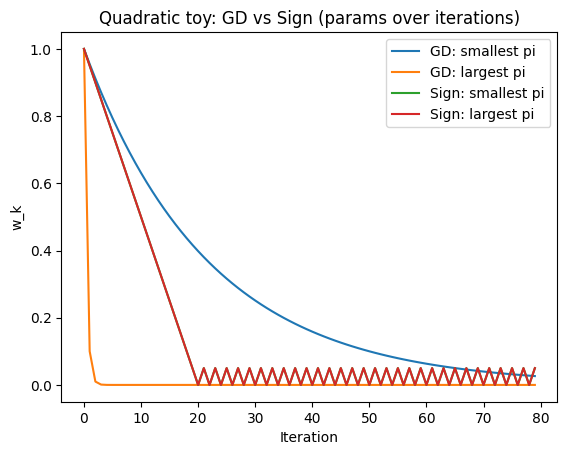

In [21]:

c = 20
pi = zipf_probs(c, s=1.0)
alpha_gd = 0.9 / (pi.max()+1e-12)  # stable
alpha_sign = 0.05
T = 80
w_gd = np.ones(c)
w_sign = np.ones(c)
traj_gd = []; traj_sign = []
for t in range(T):
    traj_gd.append(w_gd.copy()); traj_sign.append(w_sign.copy())
    w_gd = w_gd - alpha_gd * (pi * w_gd)
    w_sign = w_sign - alpha_sign * np.sign(pi * w_sign)

idx_max = int(np.argmax(pi))
idx_min = int(np.argmin(pi))
plt.figure()
plt.plot([w[idx_min] for w in traj_gd], label="GD: smallest pi")
plt.plot([w[idx_max] for w in traj_gd], label="GD: largest pi")
plt.plot([w[idx_min] for w in traj_sign], label="Sign: smallest pi")
plt.plot([w[idx_max] for w in traj_sign], label="Sign: largest pi")
plt.title("Quadratic toy: GD vs Sign (params over iterations)")
plt.xlabel("Iteration"); plt.ylabel("w_k")
plt.legend(); plt.show()



### Notes / Tips
- All sections are CPU-scaled. Increase `epochs`, `n`, `c`, and network sizes to accentuate effects.
- The linear softmax section is the fastest and already reproduces the main phenomenon (Fig. 4, Fig. 7–8).
- The CNN and TinyResNet sections mimic Fig. 2 & Fig. 3 trends with synthetic images; swap in real datasets if available.
- The optimizer ablation demonstrates that SignGD approximates Adam on rare classes (Fig. 5 trend).
- The reweighting experiment mirrors Appendix F: upweighting rare classes helps SGD.
